# Описание проекта

## Задача
Проанализируйте клиентов регионального банка и выделите портрет клиентов, которые склонны уходить из банка.

- Проведите исследовательский анализ данных,
- Выделите портреты клиентов, которые склонны уходить из банка,
- Сформулируйте и проверьте статистические гипотезы.

Описание данных:

- `userid` — идентификатор пользователя,
- `score` — баллы кредитного скоринга,
- `City` — город,
- `Gender` — пол,
- `Age` — возраст,
- `Objects` — количество объектов в собственности,
- `Balance` — баланс на счёте,
- `Products` — количество продуктов, которыми пользуется клиент,
- `CreditCard` — есть ли кредитная карта,
- `Loyalty` — активный клиент,
- `estimated_salary` — заработная плата клиента,
- `Churn` — ушёл или нет.

## Табло
https://public.tableau.com/views/custumer_churn_of_bank/Dashboard1?:language=en-US&publish=yes&:display_count=n&:origin=viz_share_link

## Шаг 1. Проанализировать датасет

In [394]:
#загрузим бибилиотеки
import pandas as pd
from pymystem3 import Mystem

from collections import Counter
from scipy import stats as st
import numpy as np
import math as mth
import matplotlib.pyplot as plt 

import seaborn as sns
import plotly.express as px

#библиотеки ML
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
import itertools
from sklearn.preprocessing import LabelEncoder

from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import roc_auc_score
import itertools


plt.rc('figure', figsize=(8, 6))



In [395]:
!pip install pandas-profiling #запускаю библиотеку для инетра

In [396]:
data = pd.read_csv('/datasets/bank_dataset.csv')
data.to_csv('bank_dataset.csv', index=False)

In [397]:
data.head(5)

userid  score       City Gender  Age  Objects    Balance  Products  \
0  15677338    619  Ярославль      Ж   42        2        NaN         1   
1  15690047    608    Рыбинск      Ж   41        1  83,807.86         1   
2  15662040    502  Ярославль      Ж   42        8 159,660.80         3   
3  15744090    699  Ярославль      Ж   39        1        NaN         2   
4  15780624    850    Рыбинск      Ж   43        2 125,510.82         1   

   CreditCard  Loyalty  estimated_salary  Churn  
0           1        1        101,348.88      1  
1           0        1        112,542.58      0  
2           1        0        113,931.57      1  
3           0        0         93,826.63      0  
4           1        1         79,084.10      0

In [398]:
from pandas_profiling import ProfileReport

In [399]:
profile = ProfileReport(data, title="Pandas Profiling Report")
profile

Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

In [400]:
#приведем названия столбцов к удобному формату нижнего регистра
data.columns = data.columns.str.lower()

In [401]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 12 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   userid            10000 non-null  int64  
 1   score             10000 non-null  int64  
 2   city              10000 non-null  object 
 3   gender            10000 non-null  object 
 4   age               10000 non-null  int64  
 5   objects           10000 non-null  int64  
 6   balance           6383 non-null   float64
 7   products          10000 non-null  int64  
 8   creditcard        10000 non-null  int64  
 9   loyalty           10000 non-null  int64  
 10  estimated_salary  10000 non-null  float64
 11  churn             10000 non-null  int64  
dtypes: float64(2), int64(8), object(2)
memory usage: 937.6+ KB


In [402]:
#сделаем читаемым формат
pd.options.display.float_format = '{:,.2f}'.format

In [403]:
data.describe().T

count          mean       std           min  \
userid           10,000.00 15,733,676.57 71,936.19 15,608,437.00   
score            10,000.00        650.53     96.65        350.00   
age              10,000.00         38.92     10.49         18.00   
objects          10,000.00          5.01      2.89          0.00   
balance           6,383.00    119,827.49 30,095.06      3,768.69   
products         10,000.00          1.53      0.58          1.00   
creditcard       10,000.00          0.71      0.46          0.00   
loyalty          10,000.00          0.52      0.50          0.00   
estimated_salary 10,000.00    100,090.24 57,510.49         11.58   
churn            10,000.00          0.20      0.40          0.00   

                           25%           50%           75%           max  
userid           15,671,264.25 15,733,474.00 15,795,969.75 15,858,426.00  
score                   584.00        652.00        718.00        850.00  
age                      32.00         37.00         44.00         92.00  
objects                   3.00          5.00          7.00         10.00  
balance             100,181.98    119,839.69    139,512.29    250,898.09  
products                  1.00          1.00          2.00          4.00  
creditcard                0.00          1.00          1.00          1.00  
loyalty                   0.00          1.00          1.00          1.00  
estimated_salary     51,002.11    100,193.91    149,388.25    199,992.48  
churn                     0.00          0.00          0.00          1.00

#### Вывод:
- Отсутствуют данные в 36% в столбце balance. Такое большое количество пропусков не позволяет просто удалить данные из датасета.
- Дубликатов нет, странное минимальное значение в зарплате ~11,58 (ниже будет рассмотрено подробнее).
- Больше всего клиентов из Ярославля (почти 50% датасета). Далее идет Ростов и Рыбинск.
- Всего 10000 строк в датасете. С типами данных все в порядке (но можно привести дополнительно зарплату к цулым значения, для анализа это не критично). 
- значение пола лучше заменить на 0 и 1 для удобства

- **Доля оттока - 20%** (не особо выглядит большой)

In [404]:
data['estimated_salary'] = data['estimated_salary'].astype('int')

In [405]:
encoder =  LabelEncoder() # создаём переменную класса LabelEncoder - кодировщик, 1-М, 0-Ж
data['gender'] = encoder.fit_transform(data['gender']) # используем кодировщик, чтобы "перевести" строковые названия в числа

In [406]:
#посмотрим распределение в столбце salary где минимальная з/п меньше среднего мрот 13890 и учтем допущение
data[data['estimated_salary'] < 10000].shape[0]

508

In [407]:
data[data['estimated_salary'] < 10000].describe()

userid  score  gender    age  objects    balance  products  \
count        508.00 508.00  508.00 508.00   508.00     300.00    508.00   
mean  15,730,848.49 647.97    0.52  38.44     4.68 118,865.35      1.55   
std       72,478.28  97.33    0.50  10.47     2.86  28,345.49      0.59   
min   15,608,947.00 413.00    0.00  18.00     0.00  27,517.15      1.00   
25%   15,671,183.75 583.00    0.00  31.00     2.00  99,550.88      1.00   
50%   15,727,905.50 648.00    1.00  37.00     4.00 118,555.41      2.00   
75%   15,792,817.00 710.00    1.00  43.00     7.00 137,062.63      2.00   
max   15,858,164.00 850.00    1.00  77.00    10.00 204,510.94      4.00   

       creditcard  loyalty  estimated_salary  churn  
count      508.00   508.00            508.00 508.00  
mean         0.67     0.51          4,959.87   0.20  
std          0.47     0.50          2,963.26   0.40  
min          0.00     0.00             11.00   0.00  
25%          0.00     0.00          2,382.75   0.00  
50%          1.00     1.00          4,794.50   0.00  
75%          1.00     1.00          7,616.00   0.00  
max          1.00     1.00          9,984.00   1.00

In [408]:
data[data['estimated_salary'] < 20]

userid  score            city  gender  age  objects    balance  \
2362  15833789    709  Ростов Великий       1   45        4 122,917.71   

      products  creditcard  loyalty  estimated_salary  churn  
2362         1           1        1                11      1

#### комментарий:
в выборке 508 строк с аномально низкими значениями з/п. Но остальные данные по таким клиентам вполне нормальные: средняя з/п ~5000, при этом на балансе  118 865 и ~2 кредитных продукта. 
Клиент с самой низкой з/п в 11,58 имеет на балансе ~123000 и является активным клиентом, при этом попал в отток. Соответсвенно удалять данные не будем и проверим далее зависимость оттока от дохода.

In [409]:
data[data['balance'].isna()].head(10)

userid  score       city  gender  age  objects  balance  products  \
0   15677338    619  Ярославль       0   42        2      NaN         1   
3   15744090    699  Ярославль       0   39        1      NaN         2   
6   15635267    822  Ярославль       1   50        7      NaN         2   
11  15779909    497    Рыбинск       1   24        3      NaN         2   
12  15675000    476  Ярославль       0   34       10      NaN         2   
13  15734219    549  Ярославль       0   25        5      NaN         2   
14  15643618    635    Рыбинск       0   35        7      NaN         2   
17  15830954    549    Рыбинск       0   24        9      NaN         2   
18  15704243    587    Рыбинск       1   45        6      NaN         1   
19  15611718    726  Ярославль       0   24        6      NaN         2   

    creditcard  loyalty  estimated_salary  churn  
0            1        1            101348      1  
3            0        0             93826      0  
6            1        1             10062      0  
11           1        0             76390      0  
12           1        0             26260      0  
13           0        0            190857      0  
14           1        1             65951      0  
17           1        1             14406      0  
18           0        0            158684      0  
19           1        1             54724      0

In [410]:
#в выборке не вижу ничего аномального, что подтверждает предположение о тех ошибке (нужно идти к разработчикам). Дополнительно еще проверю город
row = data[data['balance'].isna()]
row['city'].value_counts()

Ярославль    2418
Рыбинск      1199
Name: city, dtype: int64

предположительно система распознала 0 как отсутсвующие данные для Ярославля и Рыбинска. Это вопрос к разработчикам. Поэтому данные заполнять не будем.

In [411]:
#заполним отсутствующие данные в балансе 0
data['balance'].replace(np.nan, 0, inplace=True)

## Шаг 2. Провести исследовательский анализ данных (EDA)

### задача:
- Посмотреть на средние значения признаков в двух группах — тех, кто ушел в отток и тех, кто остался (воспользуйтесь методом groupby());
- Разделить клиентов на группы по возрасту, доходу, и активам (обычно это те пункты, что учитываются в скоринге - есть еще, но у нас нет данных)

In [412]:
#разделим пользователе на ушедших и текущих

data.groupby('churn').mean().T

churn                        0             1
userid           15,733,903.88 15,732,787.96
score                   651.85        645.35
gender                    0.57          0.44
age                      37.41         44.84
objects                   5.03          4.93
balance              72,745.30     91,108.54
products                  1.54          1.48
creditcard                0.71          0.70
loyalty                   0.55          0.36
estimated_salary     99,737.90    101,465.18

##### **План**: <br/> Делаю категории для ответов на вопросы проекта.<br/> 

Группируем по по возрасту:
- до 20 лет 
- 20-45 лет
- 45-65 лет
- более 65 лет

Группируем по доходу на три категории (исходя из средних значений)
-'низкий' (<= 30000р.);
-'средний' (30000 < x <= 100000);
-'высокий' (100000 < x);


по активам:
- 1-2 объекта
- 3-5 объектов
- 5 и более
- нет объектов

In [413]:
#сделаю категории по возрасту
def age_group(row):
    if row['age'] < 20:
        return 'до 20 лет'
    if 20 <= row['age'] < 45:
        return '20-45 лет'
    if 45 <= row['age'] <= 65:
        return '45-65 лет'
    else:
        return 'более 65 лет' 

def salary_group(row):
    if row['estimated_salary'] <= 30000:
        return 'низкий'
    if 30000 < row['estimated_salary'] <= 100000:
        return 'средний'
    return 'высокий'

def objects_group(row):
    if row['objects'] <= 0:
        return 'нет объектов'
    if 0 < row['objects'] <= 2:
        return '1-2 объекта'
    if 2 < row['objects'] <= 5:
        return '3-5 объекта'
    return 'более 5 объектов'


In [414]:
data['age_group'] = data.apply(age_group, axis =1)
data['salary_group'] = data.apply(salary_group, axis = 1)
data['objects_group'] = data.apply(objects_group, axis = 1)

In [415]:
data['age_group'].value_counts()

20-45 лет       7611
45-65 лет       2076
более 65 лет     264
до 20 лет         49
Name: age_group, dtype: int64

In [416]:
pivot1 =  data.pivot_table(index=['salary_group'], columns='churn', values = 'estimated_salary', aggfunc='count', margins=False).reset_index()
pivot1.columns = ['salary_group', 'not_churn', 'churn']
pivot1['rate'] = pivot1['churn']/(pivot1['not_churn']+pivot1['churn'])
pivot1.style.format({'rate': '{:.3f}%'})

In [417]:
data['objects_group'].value_counts()

более 5 объектов    4494
3-5 объекта         3010
1-2 объекта         2083
нет объектов         413
Name: objects_group, dtype: int64

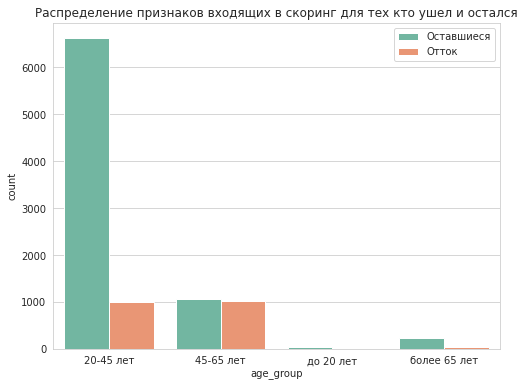

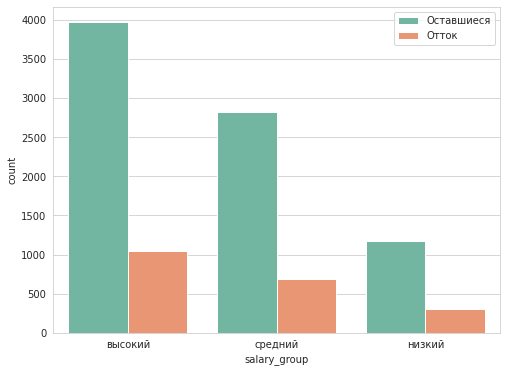

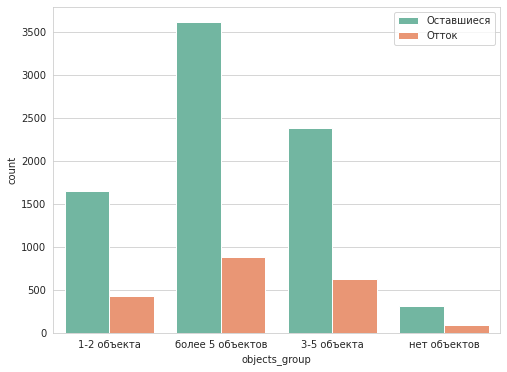

<Figure size 576x432 with 0 Axes>

In [418]:
params = ['age_group', 'salary_group', 'objects_group']
plt.title('Распределение признаков входящих в скоринг для тех кто ушел и остался')
for i in params:
    sns.countplot(x = data[i], data = data, hue = 'churn', palette = 'Set2')
    plt.legend(['Оставшиеся', 'Отток'])
    plt.show()

sns.despine(left=True)
   

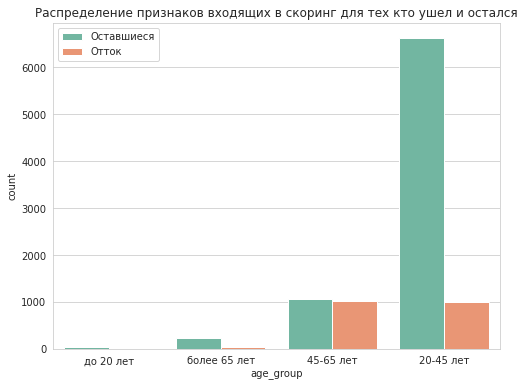

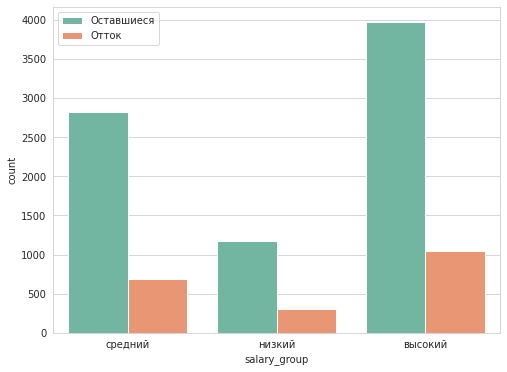

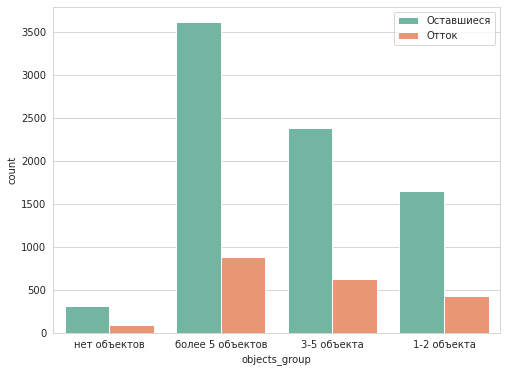

<Figure size 576x432 with 0 Axes>

In [419]:
params = ['age_group', 'salary_group', 'objects_group']
plt.title('Распределение признаков входящих в скоринг для тех кто ушел и остался')
for i in params:
    sns.countplot(x = data[i].sort_values(ascending = False), data = data, hue = 'churn', palette = 'Set2')
    plt.legend(['Оставшиеся', 'Отток'])
    plt.show()

sns.despine(left=True)

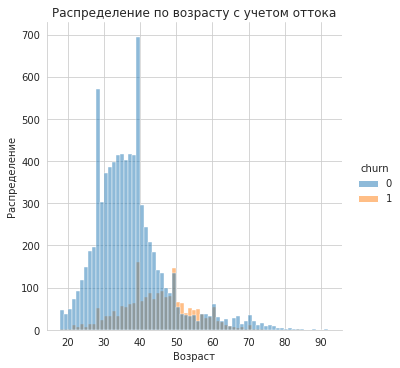

In [420]:
sns.displot(data,x='age',hue='churn')
plt.title('Распределение по возрасту с учетом оттока')
plt.xlabel('Возраст')
plt.ylabel('Распределение')
plt.show()

In [513]:
age_churn = data.groupby('age_group')['churn'].mean().reset_index()
age_churn

age_group  churn
0     20-45 лет   0.13
1     45-65 лет   0.49
2  более 65 лет   0.13
3     до 20 лет   0.06

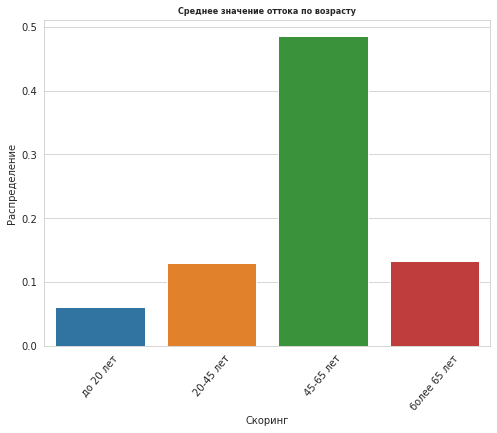

In [515]:
sns.barplot(data=age_churn, x='age_group', y = 'churn', label = 'age_group', order=['до 20 лет', '20-45 лет', '45-65 лет', 'более 65 лет'] )
plt.title('Среднее значение оттока по возрасту', fontdict={'fontsize': 8, 'fontweight': 'bold'})
plt.xlabel('Скоринг')
plt.ylabel('Распределение')
plt.xticks( rotation=50)
plt.show()


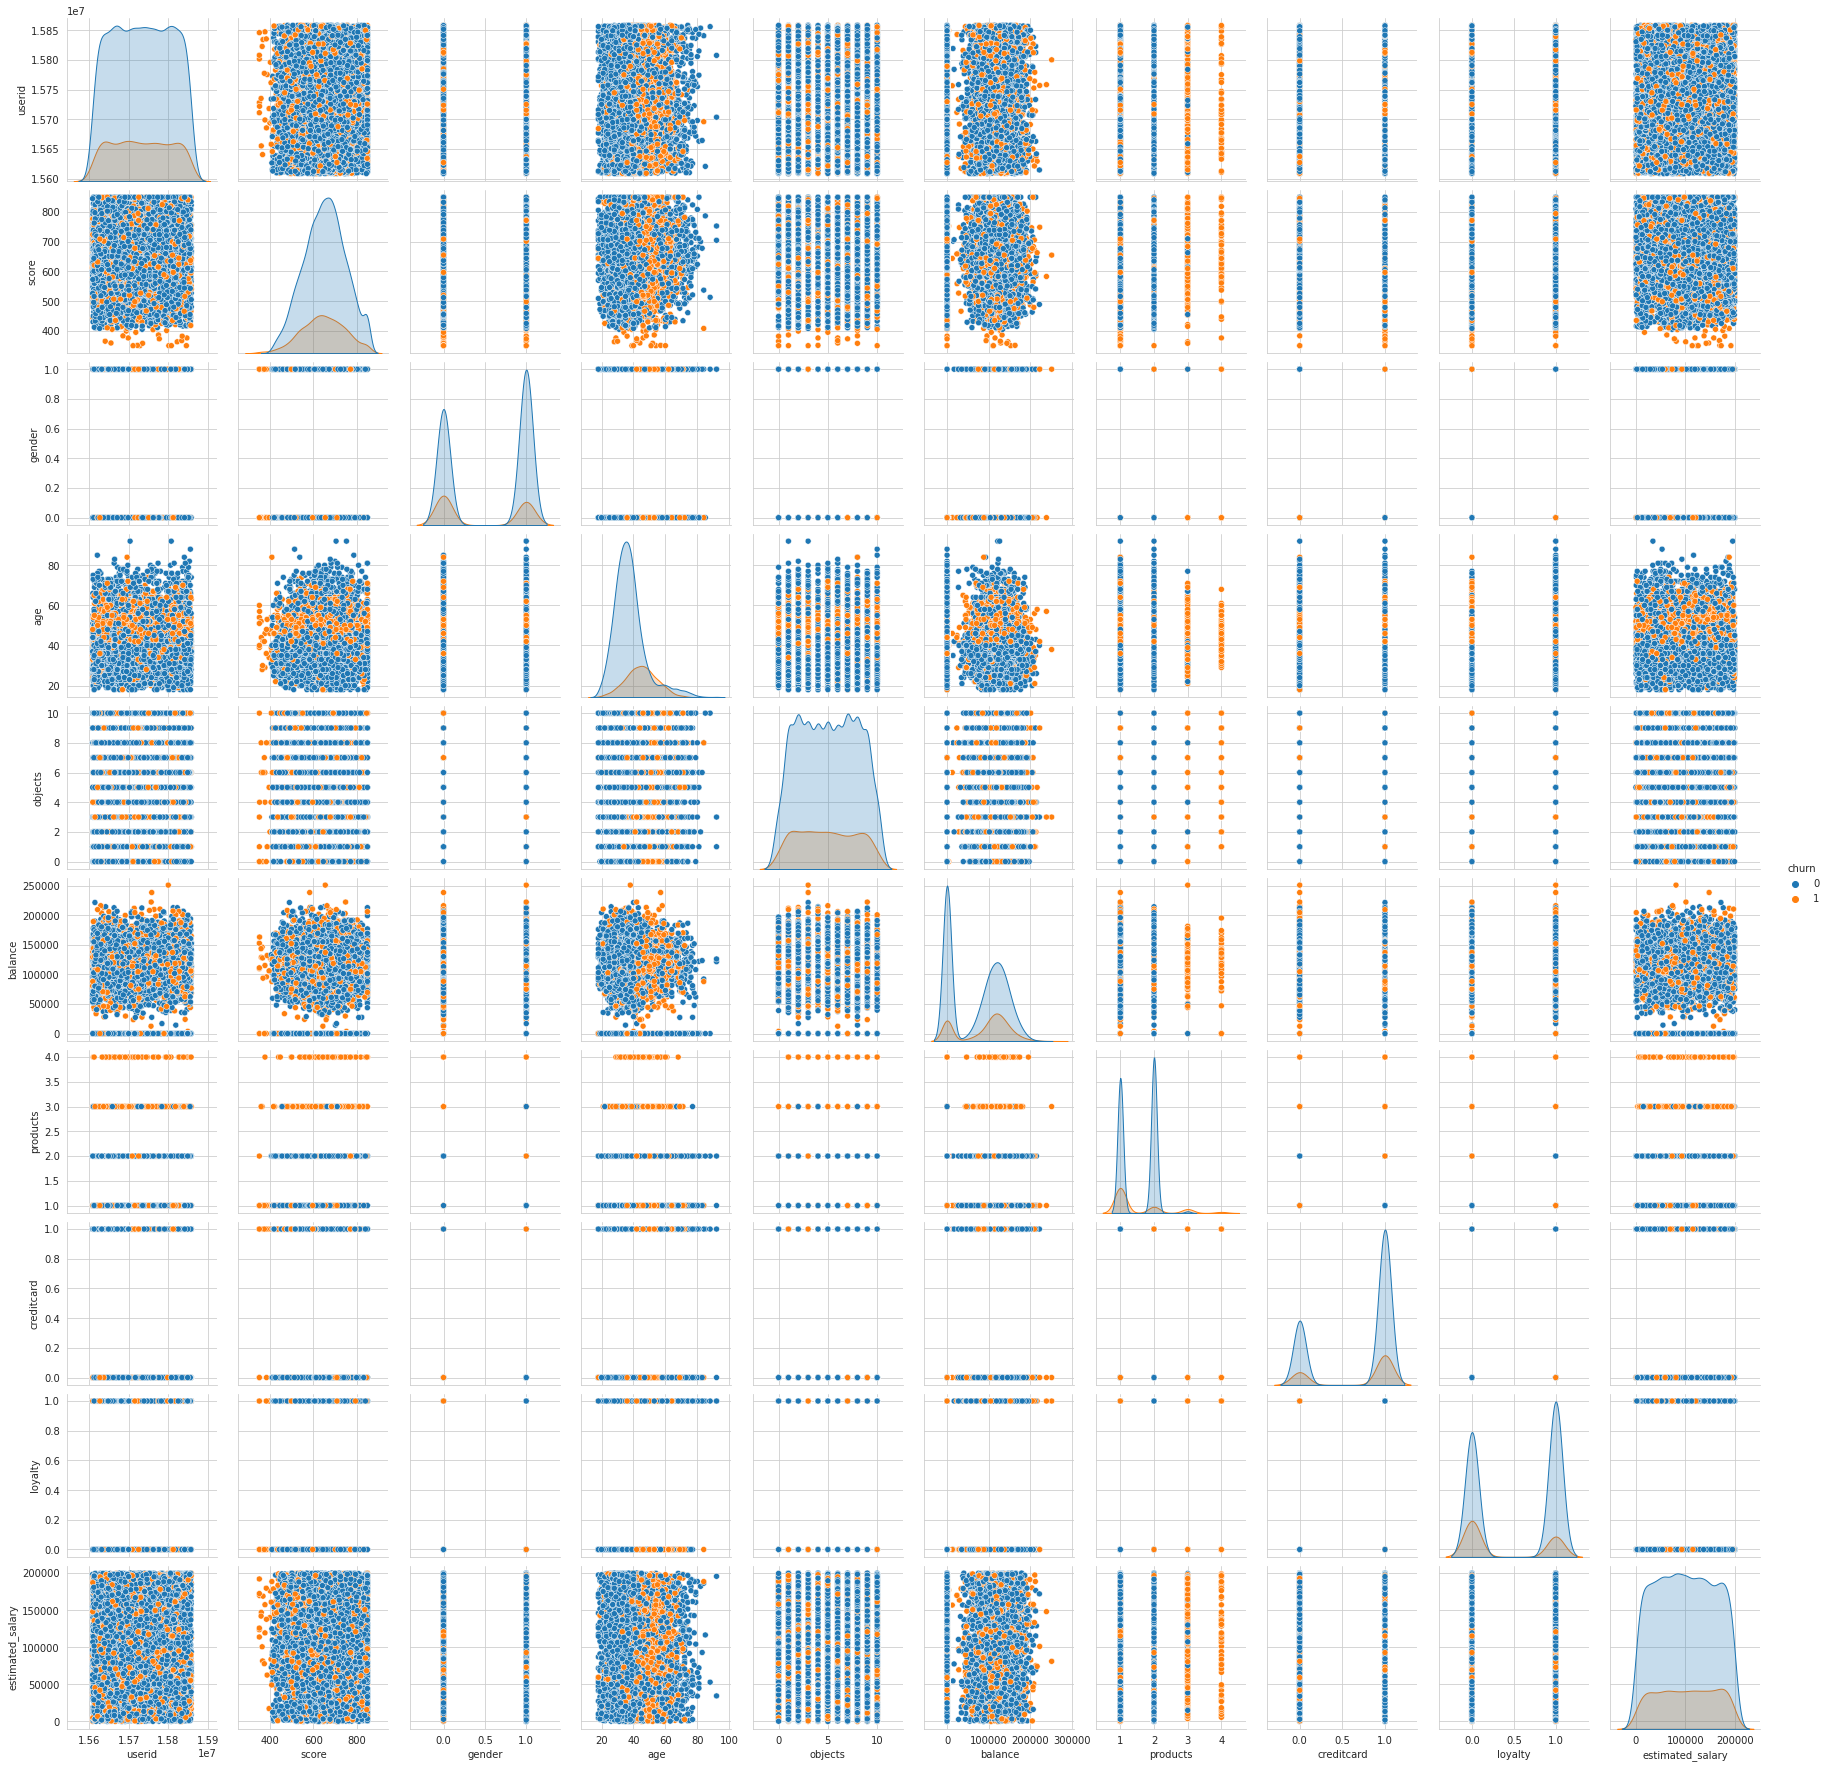

In [422]:
sns.pairplot(data,hue='churn')

#### комментарий:
- В основном в выборке представлены клиенты среднего возраста. Пенсионеров и людей моложе 20 лет мало. В отток в основном попадает группа 45+, 65+ (пенсионеры).

- В выборке 4494 клиента с наличием более 5 объектов, при этом чем больше объектов, тем больше клиентов из этой группы попадает в отток


- Аномальных зависимостей дохода от оттока не выявлено. Как и с объектами- чем больше доход, тем выше отток
- В отток попадают клиенты имеющие по скорингу в среднем 645 баллов (не сильно отличаются от тех, кто не ушел в отток)
- В оттоке чуть больше клиентов женского пола, возраст выше и чуть менее активны


### 
* Разделить клиентов по балансу на счете
* Посмотреть наличие кредитных продуктов
* Посмотреть распределение скоринга по группам клиентов
* Посмотреть распределение активности по клиентам

In [423]:
#посмотрим макс значение в датасете, так как пропуски мы не заменяли
data['balance'].max()

250898.09

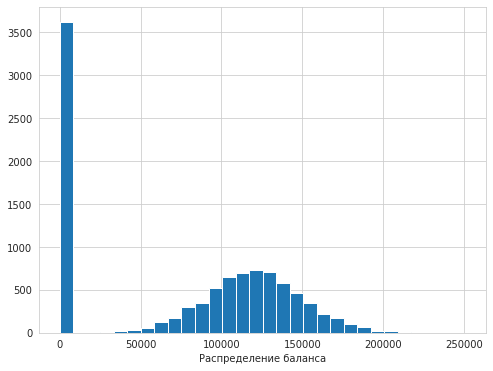

In [424]:
data['balance'].hist(bins=30)
plt.xlabel('Распределение баланса')
plt.show()

In [425]:
def balance_group(data):
    
    
    if data['balance'] <= 10000:
        return 'менее 10 000р'
    
    if 10000 < data['balance'] <= 50000:
        return '10 000 - 50 000р'
    
    if 50000 < data['balance'] <= 100000:
        return '50 000 - 100 000р'
    if 100000 < data['balance'] <= 300000:
        return 'более 100 000р'
    
    else:
        return 'нет данных'

#добавим новый столбец в таблицу
data['balance_group'] = data.apply(balance_group, axis=1)

data.head(3)

userid  score       city  gender  age  objects    balance  products  \
0  15677338    619  Ярославль       0   42        2       0.00         1   
1  15690047    608    Рыбинск       0   41        1  83,807.86         1   
2  15662040    502  Ярославль       0   42        8 159,660.80         3   

   creditcard  loyalty  estimated_salary  churn  age_group salary_group  \
0           1        1            101348      1  20-45 лет      высокий   
1           0        1            112542      0  20-45 лет      высокий   
2           1        0            113931      1  20-45 лет      высокий   

      objects_group      balance_group  
0       1-2 объекта      менее 10 000р  
1       1-2 объекта  50 000 - 100 000р  
2  более 5 объектов     более 100 000р

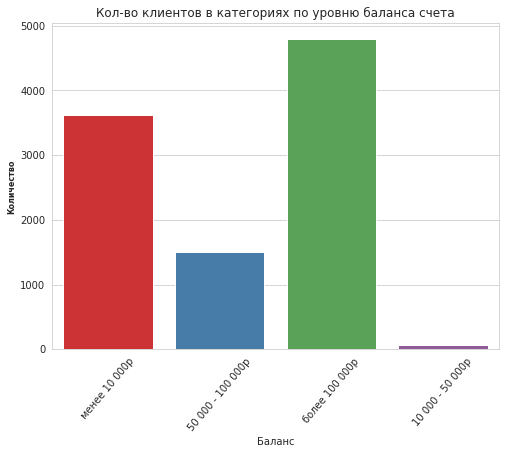

In [426]:
sns.countplot( data = data, x = 'balance_group',   palette = 'Set1')
plt.title('Кол-во клиентов в категориях по уровню баланса счета')
plt.ylabel('Количество', fontdict={'fontsize': 8, 'fontweight': 'bold'}) 
plt.xlabel('Баланс')
plt.xticks( rotation=50)
plt.show()

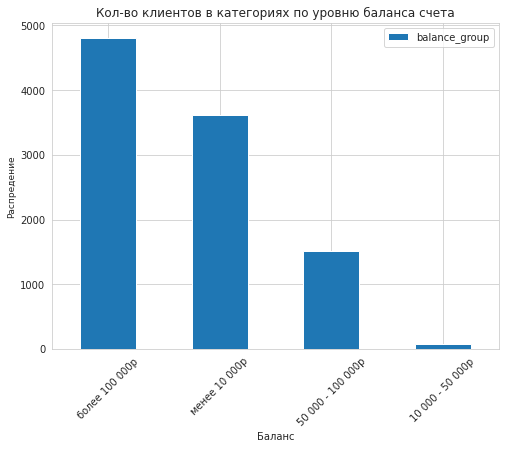

In [427]:
data['balance_group'].value_counts().plot(kind='bar', rot=45)
plt.xlabel('Баланс')
plt.ylabel('Распредение',fontsize=9)
plt.title('Кол-во клиентов в категориях по уровню баланса счета')
plt.legend()
plt.show()

In [428]:
a = data.groupby('balance_group')['balance'].count().sort_values( ascending = False).reset_index()
a

balance_group  balance
0     более 100 000р     4799
1      менее 10 000р     3618
2  50 000 - 100 000р     1509
3   10 000 - 50 000р       74

Text(0.5, 1.0, 'Кол-во клиентов в категориях по уровню баланса счета')

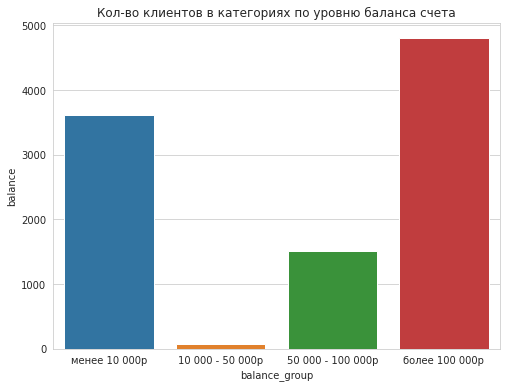

In [429]:
sns.barplot(data=a, x='balance_group', y = 'balance', label = 'balance_group', order=['менее 10 000р', '10 000 - 50 000р','50 000 - 100 000р', 'более 100 000р'] )
plt.title('Кол-во клиентов в категориях по уровню баланса счета')

In [430]:
pivot2 = data.pivot_table(index=['churn', 'products'], columns='creditcard', values = 'userid', aggfunc='count').reset_index()
pivot2.columns = ['churn','products', 'not_creditcard', 'creditcard']
pivot2['rate'] = pivot2['creditcard']/(pivot2['not_creditcard']+pivot2['creditcard'])
pivot2['count_products'] = pivot2['not_creditcard']+pivot2['creditcard']
pivot2.style.format({'rate': '{:.2f}%'})

Text(0.5, 1.0, 'Распределение в датасете наличия кредитных продуктов с учетом наличия кредитных карт')

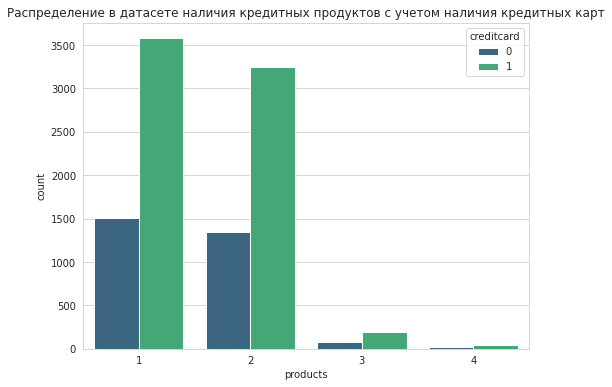

In [431]:
sns.countplot(x = 'products', data = data, hue = 'creditcard', palette = 'viridis')
plt.title('Распределение в датасете наличия кредитных продуктов с учетом наличия кредитных карт')

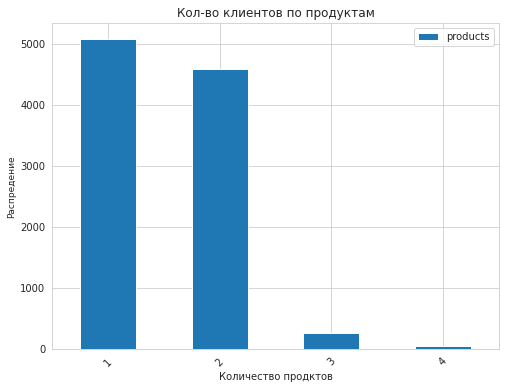

In [432]:
data['products'].value_counts().plot(kind='bar', rot=45)
plt.xlabel('Количество продктов')
plt.ylabel('Распредение',fontsize=9)
plt.title('Кол-во клиентов по продуктам')
plt.legend()
plt.show()

In [433]:
#разделим скоринг на категории (ранее мы видели на графике в отчете распределение)
def score_group(data):
    
    if data['score'] < 500:
        return 'до 500 баллов'
    
    elif data['score'] <= 650:
        return '500-650 баллов'
    
    else:
        return 'более 650 баллов'

#добавим новый столбец в таблицу
data['score_group'] = data.apply(score_group, axis=1)

In [434]:
data['score_group'].value_counts()

более 650 баллов    5063
500-650 баллов      4305
до 500 баллов        632
Name: score_group, dtype: int64

In [435]:
score_churn = data.groupby('score_group')['churn'].mean().reset_index()
score_churn

score_group  churn
0    500-650 баллов   0.21
1  более 650 баллов   0.19
2     до 500 баллов   0.24

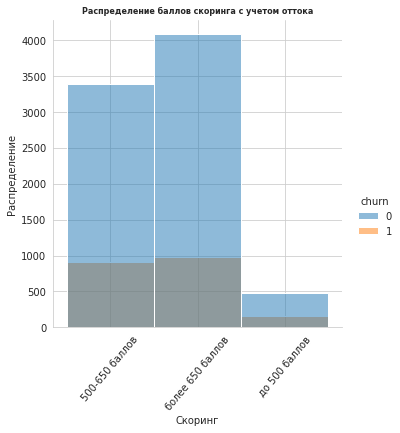

In [436]:
sns.displot(data,x='score_group',hue='churn', bins = 10)
plt.title('Распределение баллов скоринга с учетом оттока', fontdict={'fontsize': 8, 'fontweight': 'bold'})
plt.xlabel('Скоринг')
plt.ylabel('Распределение')
plt.xticks( rotation=50)
plt.show()

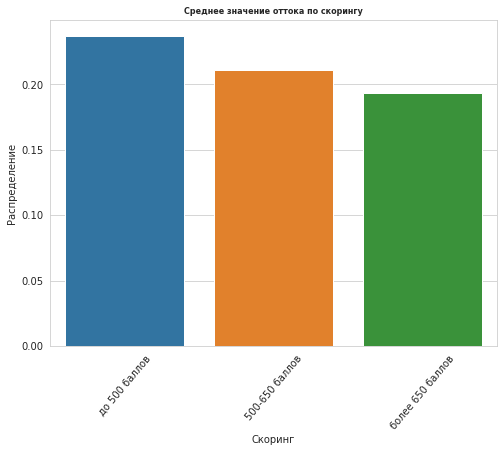

In [437]:
sns.barplot(data=score_churn, x='score_group', y = 'churn', label = 'score_group', order=['до 500 баллов', '500-650 баллов','более 650 баллов'] )
plt.title('Среднее значение оттока по скорингу', fontdict={'fontsize': 8, 'fontweight': 'bold'})
plt.xlabel('Скоринг')
plt.ylabel('Распределение')
plt.xticks( rotation=50)
plt.show()

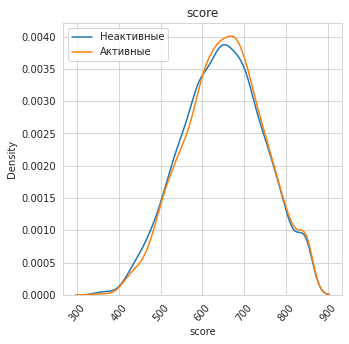

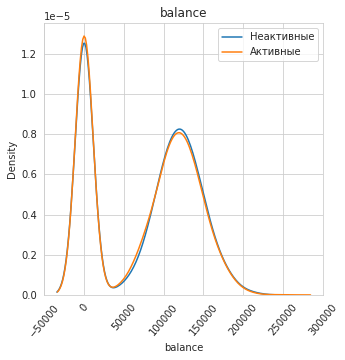

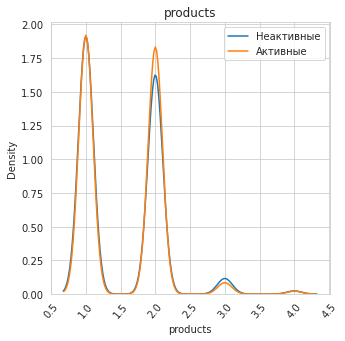

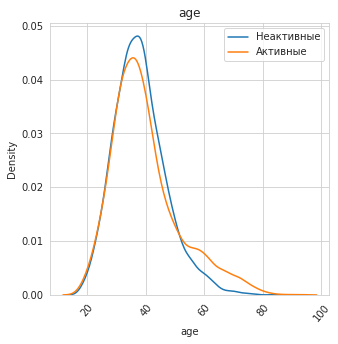

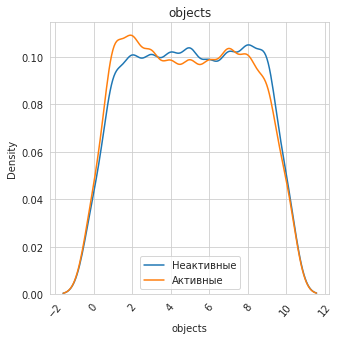

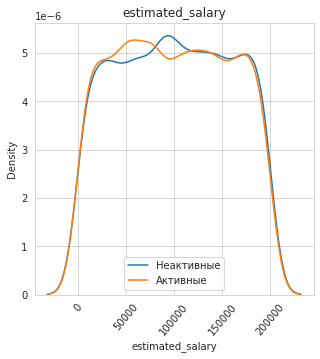

In [438]:
for i in ['score',  'balance', 'products', 'age', 'objects','estimated_salary']:
    plt.figure(figsize=(5, 5))
    plt.title(i)   
    sns.kdeplot(data.query('loyalty==0')[i], label = 'Неактивные')
    sns.kdeplot(data.query('loyalty==1')[i], label = 'Активные')
    sns.set_style('whitegrid')
    plt.xticks( rotation=50)
    plt.legend()
    plt.show()

#### комментарий:
- В основном на балансе клиентов более 100 000.

- больше всего в датасете клиентов с 1-2 кредитными продуктами, имеющие 3-4 чаще попадают в отток (клиенты, которые имеют 2 продукта реже всего уходят
- в основном клиенты датасета имеют высокий скоринговый балл


#### 
- Построить столбчатые гистограммы и распределения признаков для тех, кто ушёл (отток) и тех, кто остался (не попали в отток);
- Построить матрицу корреляций и отобразить её.

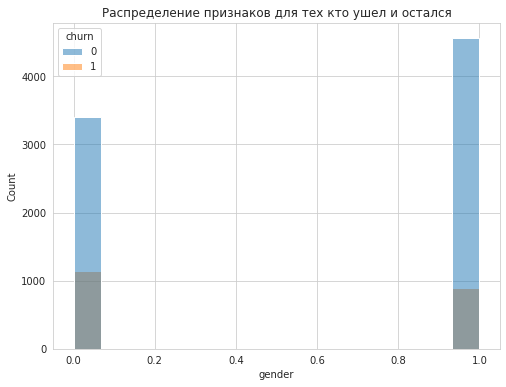

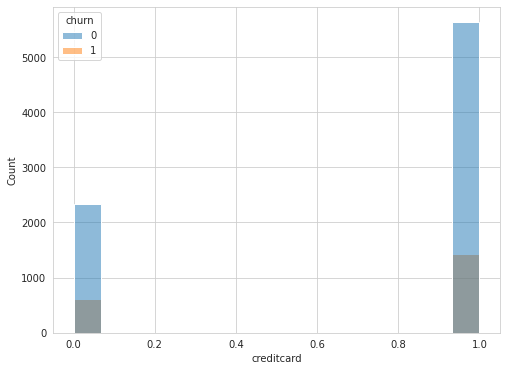

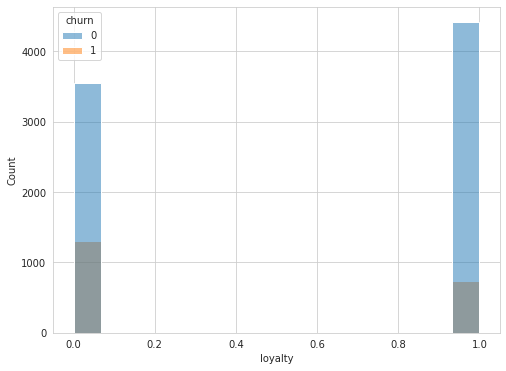

In [439]:
#построим сначала графики для бинарных признаков
params = ['gender', 'creditcard', 'loyalty']
plt.title('Распределение признаков для тех кто ушел и остался')
for a, i in enumerate(params):
    sns.histplot(data=data, x=i, hue="churn")
    plt.show()

In [495]:
gender_churn = data.groupby('gender')['churn'].sum().reset_index()
gender_churn['gender'] = data.gender.value_counts()
gender_churn.reset_index()

index  gender  churn
0      0    4543   1139
1      1    5457    898

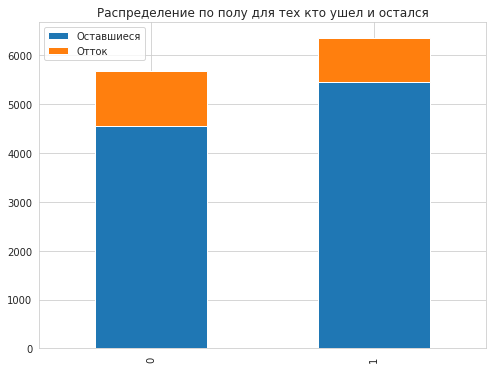

In [504]:
gender_churn.plot(kind='bar', stacked = True)
plt.title('Распределение по полу для тех кто ушел и остался')
plt.legend(['Оставшиеся', 'Отток'])

In [501]:
loyl_churn = data.groupby('loyalty')['churn'].sum().reset_index()
loyl_churn['loyalty'] = data.loyalty.value_counts()
loyl_churn.reset_index()

index  loyalty  churn
0      0     4849   1302
1      1     5151    735

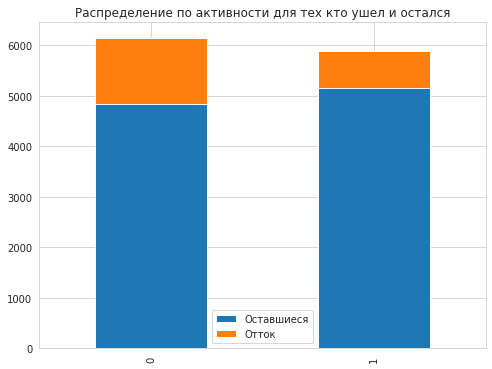

In [505]:
loyl_churn.plot(kind='bar', stacked = True)
plt.title('Распределение по активности для тех кто ушел и остался')
plt.legend(['Оставшиеся', 'Отток'])

In [440]:
import warnings
warnings.filterwarnings('ignore')

In [441]:
#гистограммы лучше подойдут для непрерывных переменных, выделим параметры в них
params2 = ['score', 'age', 'objects', 'balance', 'products', 'estimated_salary' ] 
col_count, row_count = 3, 2 #зададим число строк и столбцов

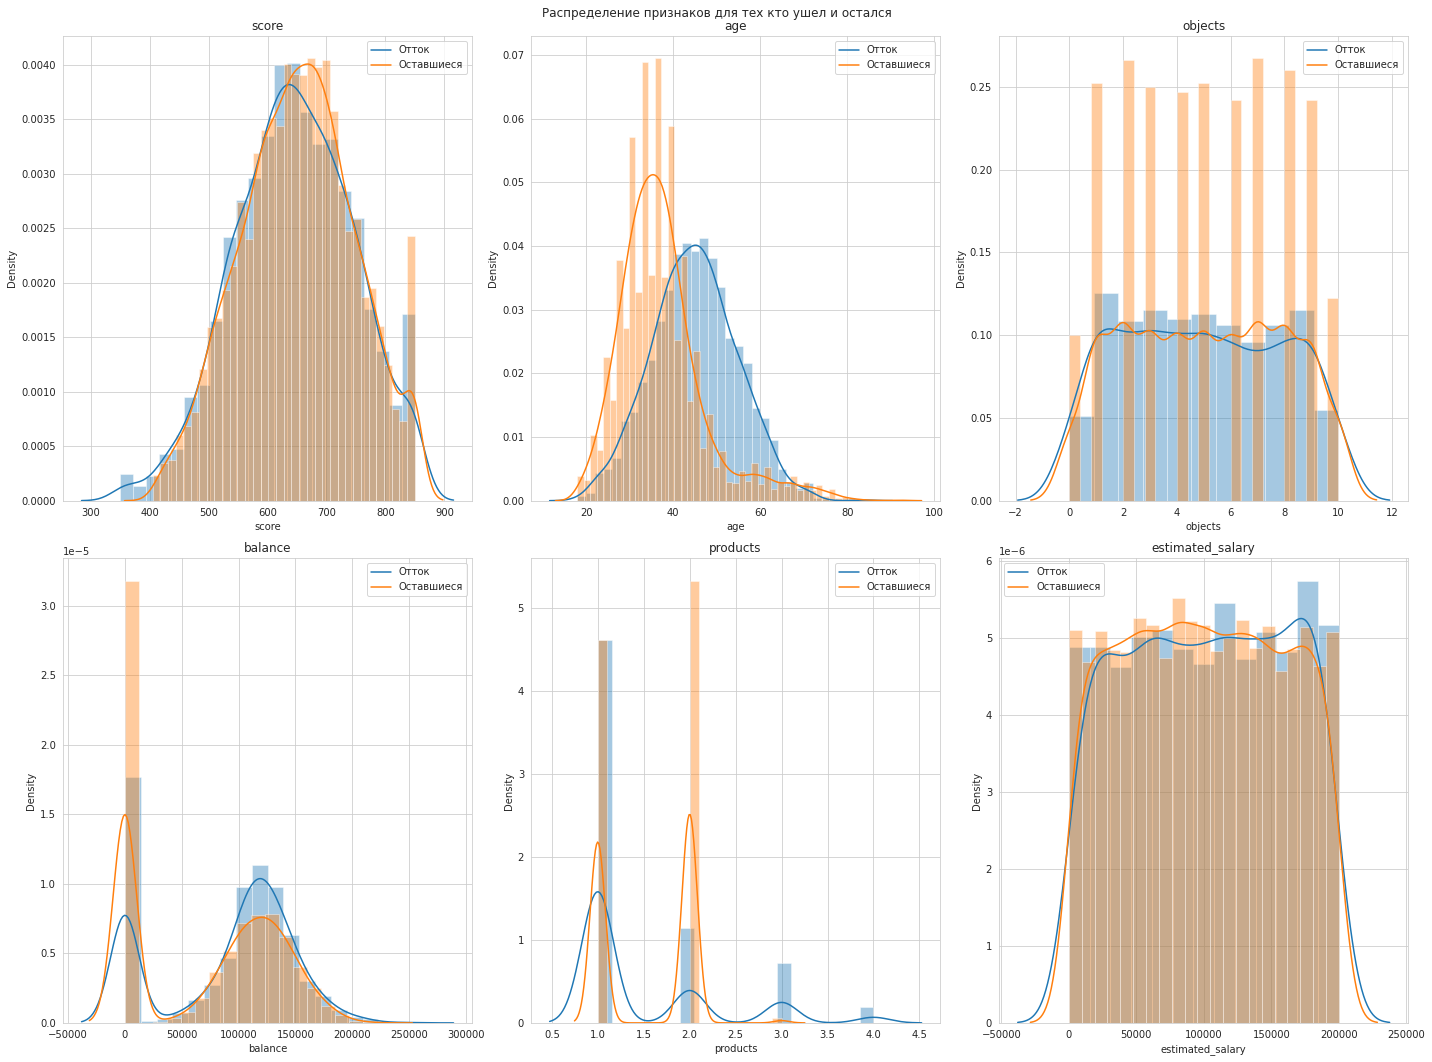

In [442]:
plt.figure (figsize = (20,15))
for i, param in enumerate(params2):
            for churn in data['churn'].unique():
                current = data.query('churn == @churn')
                sns.distplot(current[param], label = churn, ax = plt.subplot(row_count, col_count, i + 1))
                plt.legend(['Отток', 'Оставшиеся'])#i+1 порядковый номер графика
            plt.title(param)
plt.suptitle('Распределение признаков для тех кто ушел и остался')
plt.tight_layout()

<div class="alert alert-warning">
<b>Хорошо, но можно и лучше: ❗️</b> 
    
Из-за того, что ты рисуешь как два разных распределения, в каждом по-своему определились бины и поэтому на некоторых графиках они выглядят по-разному. 
</div>

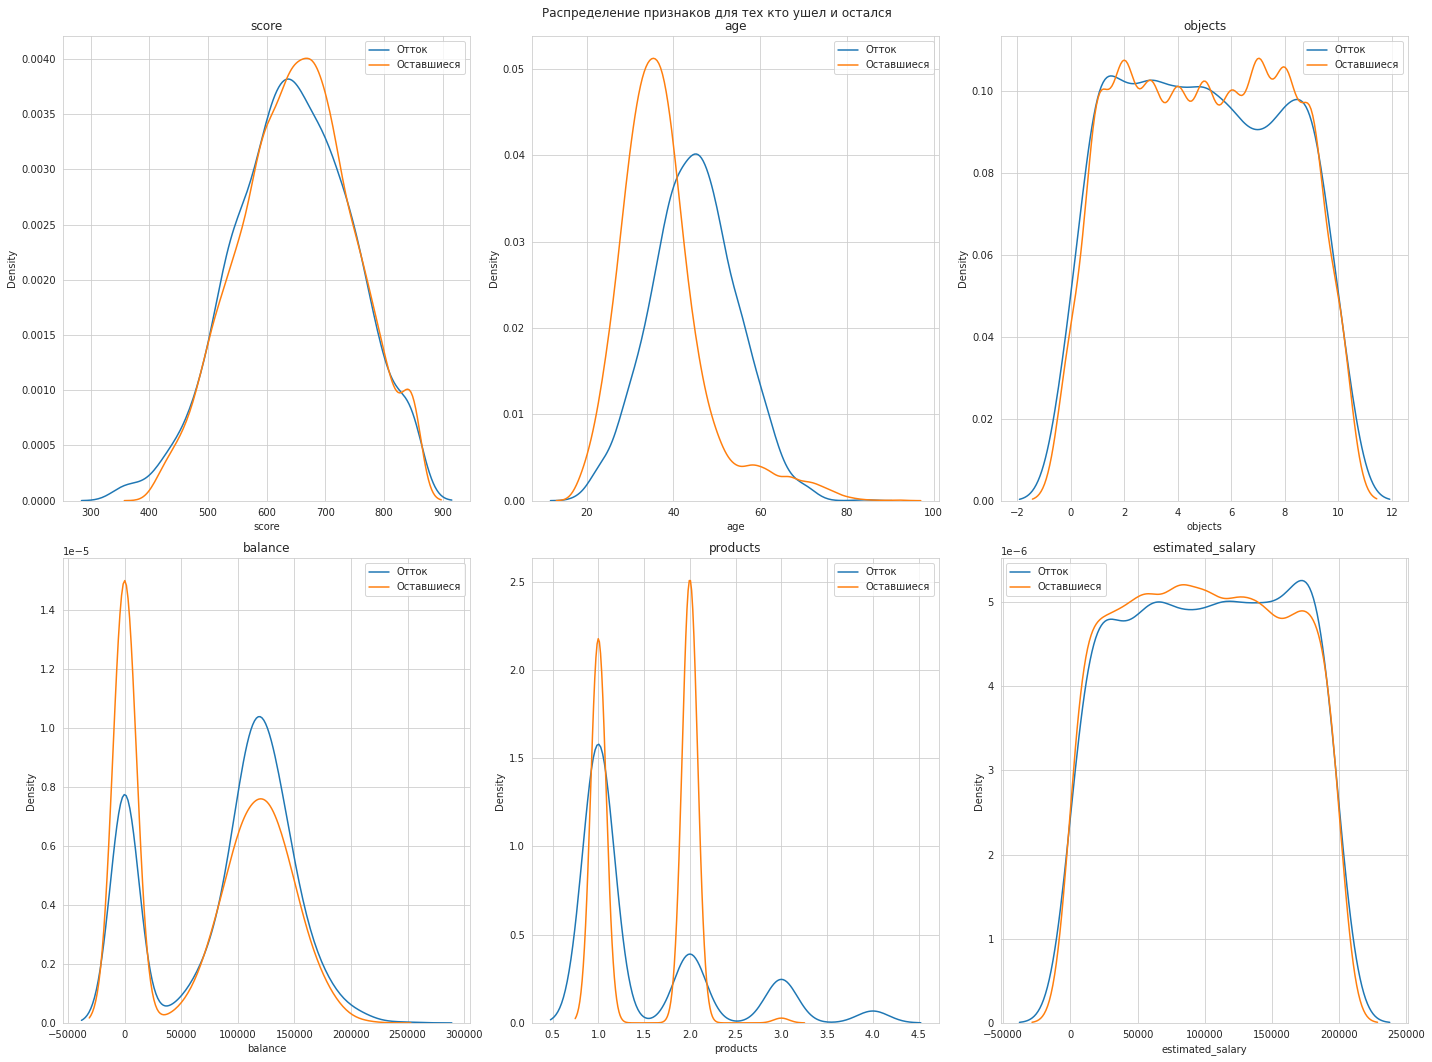

In [443]:
plt.figure (figsize = (20,15))
for i, param in enumerate(params2):
            for churn in data['churn'].unique():
                current = data.query('churn == @churn')
                sns.kdeplot(current[param], label = churn, ax = plt.subplot(row_count, col_count, i + 1))
                plt.legend(['Отток', 'Оставшиеся'])#i+1 порядковый номер графика
            plt.title(param)
plt.suptitle('Распределение признаков для тех кто ушел и остался')
plt.tight_layout()

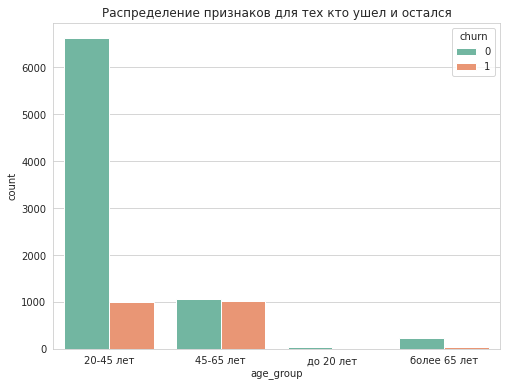

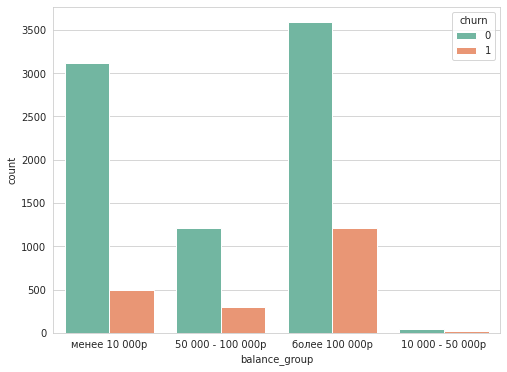

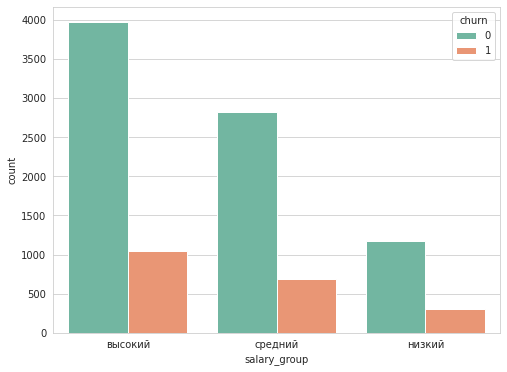

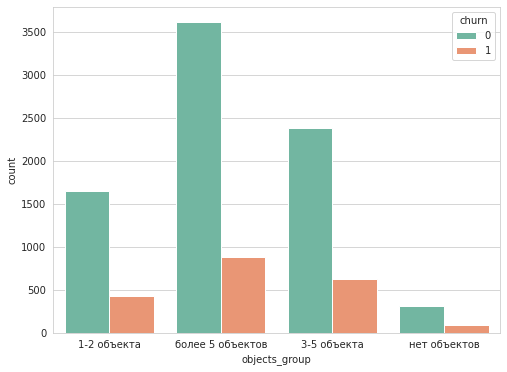

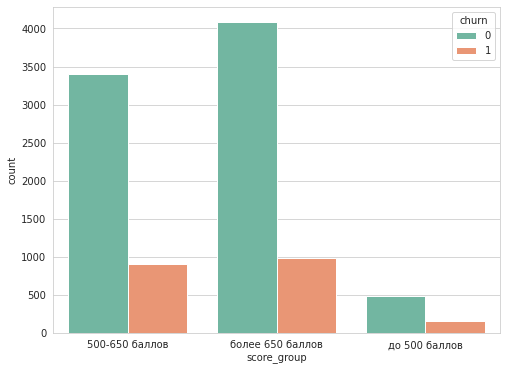

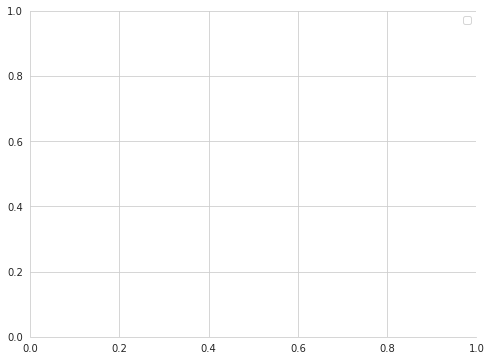

In [444]:
params3 = ['age_group','balance_group', 'salary_group', 'objects_group', 'score_group' ]
plt.title('Распределение признаков для тех кто ушел и остался')
for i in params3:
    sns.countplot(x = data[i], hue='churn', data=data, palette = "Set2")
    plt.show()
    plt.legend(['Отток', 'Оставшиеся'])

sns.despine(left=True)

<div class="alert alert-warning">
<b>Хорошо, но можно и лучше: ❗️</b> 
    
Та же идея про среднее значение оттока в каждой группе, чтобы избавиться от проблемы с масштабами.
</div>

In [445]:
corr_map = data.corr()

<AxesSubplot:>

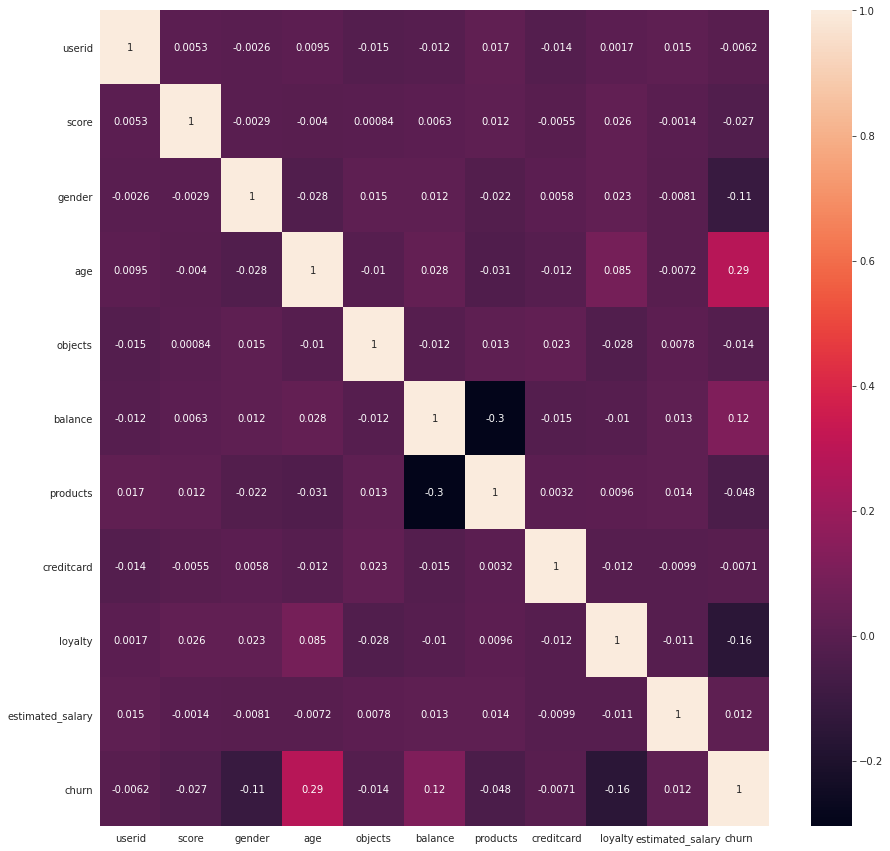

In [446]:
plt.figure(figsize = (15,15))
sns.heatmap(corr_map, annot = True)

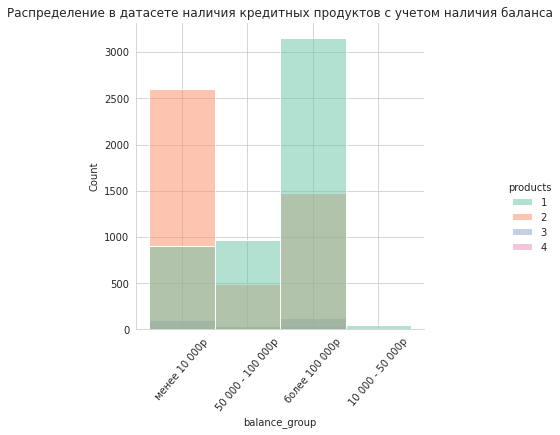

In [447]:
sns.displot(x = 'balance_group', data = data, hue = 'products', palette = 'Set2')
plt.title('Распределение в датасете наличия кредитных продуктов с учетом наличия баланса')
plt.xticks( rotation=50)
plt.show()

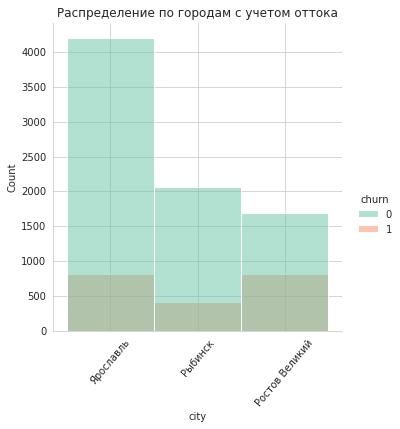

In [448]:
#проверим город (дополнительно)
sns.displot(x = 'city', data = data, hue = 'churn', palette = 'Set2')
plt.title('Распределение по городам с учетом оттока')
plt.xticks( rotation=50)
plt.show()

In [449]:
pivot3 = data.pivot_table(index='churn', columns='city', values = 'userid', aggfunc='count').reset_index()
pivot3


city  churn  Ростов Великий  Рыбинск  Ярославль
0         0            1695     2064       4204
1         1             814      413        810

#### комментарий:
-  По матрице корреляций можно сказать, что влияние на отток имеют такие признаки как возраст, активность (слабая корреляция), пол (слабая корреляция), баланс (небольшая корреляция) и кол-во продуктов.
-  Такие признаки как заработная плата, наличие кредитной карты, количество объектов в собственности почти никак не влияют на отток (очень слабо)
- Баланс счета довольно сильно коррелирует с количеством продуктов, которыми пользуется клиент (больше баланс - меньшее кол-во кредитных продуктов, менее активные клиенты)

#### Вывод по EDA:
- В основном в выборке представлены клиенты среднего возраста. Пенсионеров и людей моложе 20 лет мало. В отток в основном попадают клиенты 45+ (в том числе пенсионеры) . При этом такая группа более активна (возможно уходят в отток так как не проходят уже под требования банка далее)

- Клиенты имеющие менее 2 объектов более активны, при этом в отток попадают чаще те, кто не имеют объекты в собственности или наоборот имеют более 5
- В отток уходят менее активные клиенты (кроме признака с возрастом)
- Аномальных зависимостей дохода от оттока не выявлено. Как и с объектами- чем больше доход, тем выше отток
- В отток попадают клиенты имеющие по скорингу в среднем 645 баллов (не сильно отличаются от тех, кто не ушел в отток)
- В оттоке чуть больше клиентов женского пола, которые чуть менее активны

- Больше всего в датасете клиентов с 1-2 кредитными продуктами, имеющие 3-4 чаще попадают в отток (клиенты, которые имеют 2 продукта реже всего уходят)
- в основном клиенты датасета имеют высокий скоринговый балл
- Клиенты с зп менее 100000 более активны
- Больше всего клиентов с оттоком в ростове великом



## Шаг 3. Сделать кластеризацию клиентов
Отложить в сторону столбец с оттоком и провести кластеризацию объектов (клиентов):

Стандартизировать данные.
Построить матрицу расстояний функцией linkage() на стандартизованной матрице признаков и нарисовать дендрограмму. На основании полученного графика предположить, какое количество кластеров можно выделить.
Обучить модель кластеризации на основании алгоритма K-Means и спрогнозируйте кластеры клиентов.
Посмотреть на средние значения признаков для кластеров.
Построить распределения признаков для кластеров.
Для каждого полученного кластера посчитать долю оттока (методом groupby()).
На основе получившегося анализа вывести портреты клиентов, которые уходят в отток и остаются

In [450]:
df =  data.drop(['churn'], axis=1)

In [451]:
df['city_bin'] = df['city'].copy() 

In [452]:
df['city_bin'] = df['city_bin'].replace({'Ярославль':0, 'Рыбинск': 1, 'Ростов Великий': 2})

In [453]:
df2 = df.copy()

In [454]:
df2 = df2.drop(['age_group','balance_group', 'salary_group', 'objects_group', 'score_group', 'city_bin', 'userid'], axis = 1)

In [455]:
df2 = pd.get_dummies(df2) 

In [456]:
df2.head(3)

score  gender  age  objects    balance  products  creditcard  loyalty  \
0    619       0   42        2       0.00         1           1        1   
1    608       0   41        1  83,807.86         1           0        1   
2    502       0   42        8 159,660.80         3           1        0   

   estimated_salary  city_Ростов Великий  city_Рыбинск  city_Ярославль  
0            101348                    0             0               1  
1            112542                    0             1               0  
2            113931                    0             0               1

In [457]:
df.head(3)

userid  score       city  gender  age  objects    balance  products  \
0  15677338    619  Ярославль       0   42        2       0.00         1   
1  15690047    608    Рыбинск       0   41        1  83,807.86         1   
2  15662040    502  Ярославль       0   42        8 159,660.80         3   

   creditcard  loyalty  estimated_salary  age_group salary_group  \
0           1        1            101348  20-45 лет      высокий   
1           0        1            112542  20-45 лет      высокий   
2           1        0            113931  20-45 лет      высокий   

      objects_group      balance_group     score_group  city_bin  
0       1-2 объекта      менее 10 000р  500-650 баллов         0  
1       1-2 объекта  50 000 - 100 000р  500-650 баллов         1  
2  более 5 объектов     более 100 000р  500-650 баллов         0

In [458]:
df_new= df.drop(['city','age_group','balance_group', 'salary_group', 'objects_group', 'score_group'], axis = 1)

In [459]:
df_new.columns

Index(['userid', 'score', 'gender', 'age', 'objects', 'balance', 'products',
       'creditcard', 'loyalty', 'estimated_salary', 'city_bin'],
      dtype='object')

In [460]:
from scipy.cluster.hierarchy import dendrogram, linkage

In [461]:
# стандартизируем данные
sc = StandardScaler()
X_sc = sc.fit_transform(df2)

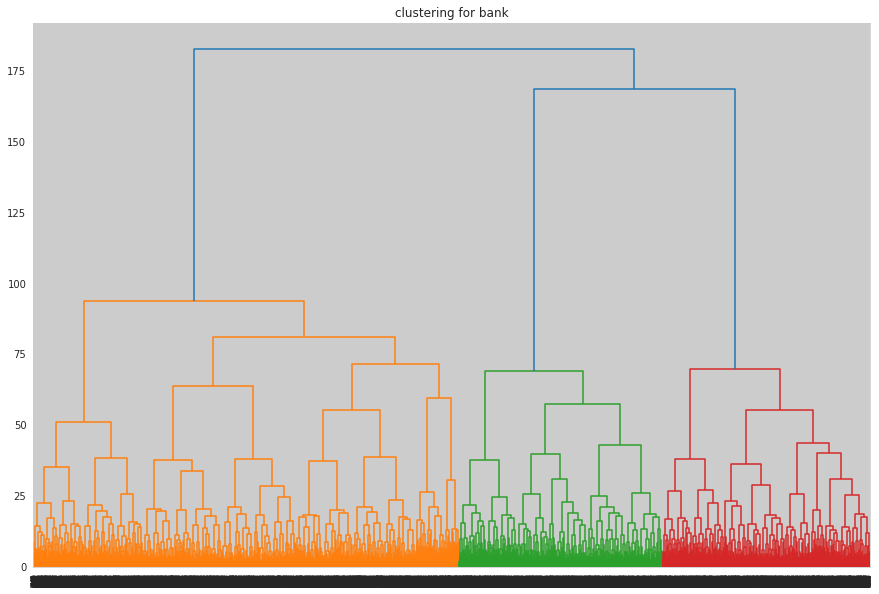

In [462]:
linked = linkage(X_sc, method = 'ward')
plt.figure(figsize=(15, 10))  
dendrogram(linked, orientation='top')
plt.title('clustering for bank')
plt.show()

In [506]:
# задаём модель k_means с числом кластеров 4 и фиксируем значение random_state
km = KMeans(n_clusters=4, random_state=0)
# прогнозируем кластеры для наблюдений (алгоритм присваивает им номера от 0 )
labels = km.fit_predict(X_sc)

# сохраняем метки кластера в поле нашего датасета
data['cluster'] = labels


In [507]:
from sklearn.metrics import silhouette_score

silhouette_score(X_sc, labels)

0.15703099116459737

In [508]:
data.groupby('cluster').mean().T

cluster                      0             1             2             3
userid           15,734,654.41 15,733,291.65 15,732,226.97 15,734,449.52
score                   651.33        651.45        650.87        648.56
gender                    0.56          0.52          0.56          0.53
age                      38.89         39.77         38.45         38.57
objects                   5.03          5.01          4.93          5.07
balance              61,818.15    119,730.12    122,858.10      6,346.42
products                  1.54          1.52          1.21          1.82
creditcard                0.69          0.71          0.70          0.71
loyalty                   0.53          0.50          0.51          0.53
estimated_salary     99,440.08    101,112.94    100,541.67     99,308.82
churn                     0.17          0.32          0.16          0.16

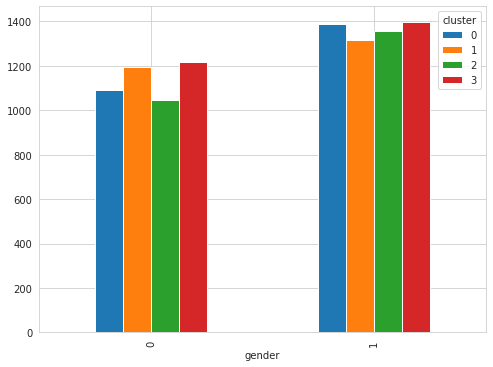

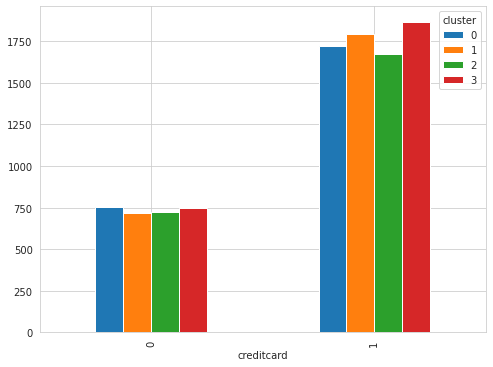

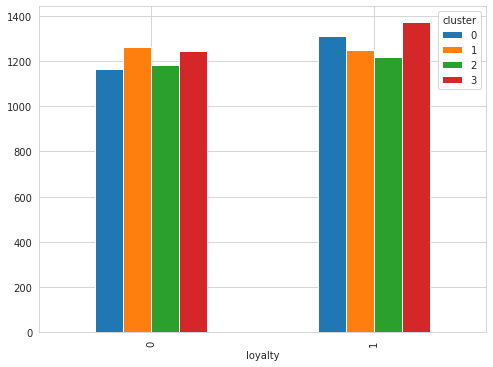

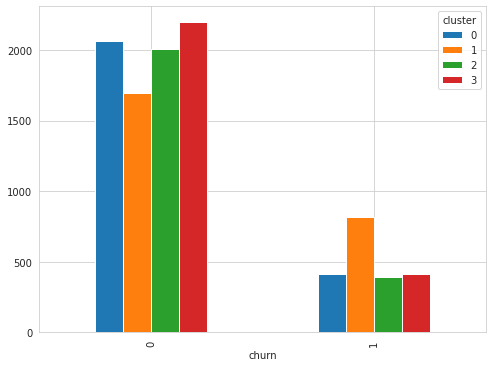

In [509]:
#построим столбчатые диагрумму для  признаков
#в цикле перебираем все столбцы датасета
for col in data.columns:
    if col =='cluster': continue
    if data[col].nunique() < 3:
        data.reset_index().pivot_table(index = col, columns = 'cluster', values = 'index', aggfunc = 'count').plot(kind = 'bar')

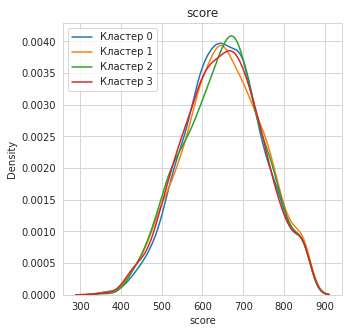

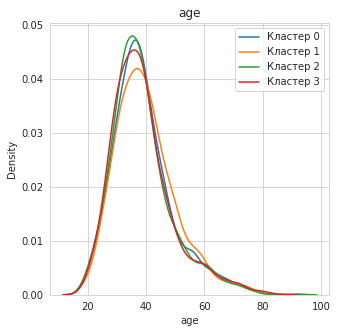

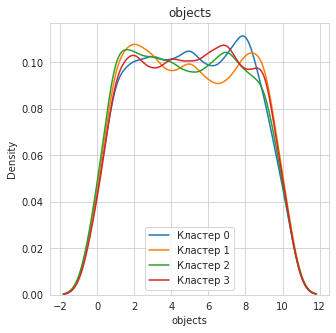

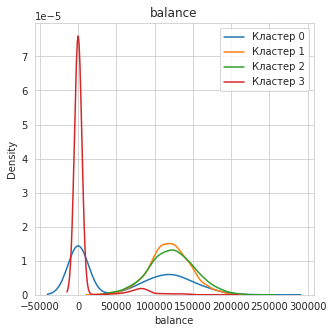

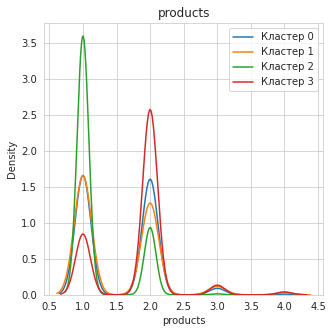

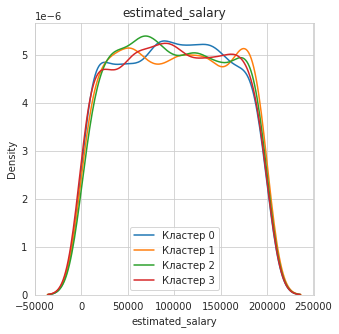

In [510]:
for column in ['score', 'age', 'objects', 'balance', 'products', 'estimated_salary']:
        plt.figure(figsize=(5, 5))
        plt.title(column)   
        sns.kdeplot(data.query('cluster==0')[column], label = 'Кластер 0')
        sns.kdeplot(data.query('cluster==1')[column], label = 'Кластер 1')
        sns.kdeplot(data.query('cluster==2')[column], label = 'Кластер 2')
        sns.kdeplot(data.query('cluster==3')[column], label = 'Кластер 3')
        plt.legend()

<AxesSubplot:xlabel='products'>

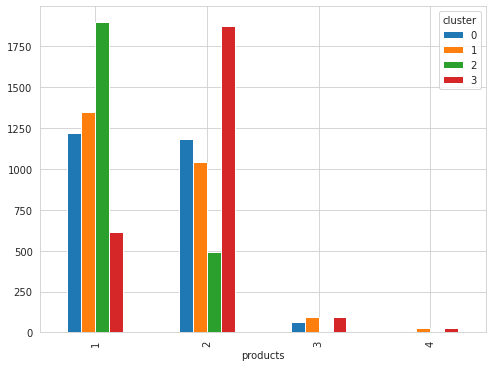

In [511]:
data.reset_index().pivot_table(index = 'products', columns = 'cluster', values = 'index', aggfunc = 'count').plot(kind = 'bar')

#### Вывод:
Выделили 4 кластера. Самым многочисленным кластером по оттоку является 1-й, затем идет 0-ой. Самый малочисленный - 2 и 3-й. 
Самый большой отток в 1 кластере - 32%, затем в 1 - 17% и в 2 и 3 - 16%.

уже по средним значениям видно подтверждение ранее сделанных выводов (на примере 1 класса):
- высокий баланс
- 40-60  средний возраст
- 2 и более 8 объектов в собственности
- высокая з/п
- ниже скоринговый балл при этом
- в основном 1 кредитный продукт, есть 3 и 4
- баланс 100 000+

в самом маленьком по оттоке кластере - 2 и 3 (16%): (клиенты менее склонные уходить в отток)
- самый низкий баланс и самая низкое среднее значение з/п
- больше продуктов кредитных
- лояльные клиенты, в среднем 1-2 кредитных продукта встречаются чаще


<div class="alert alert-success">
<b>Все отлично: ✅</b> 
    
    
Очень хорошо. Могу поделиться небольшим лайф-хаком. Одним из параметров KMeans является init.  

Этот параметр может принимать матрицу размера (n_clusters, n_features). Если определить ее случайно (например: centroids = np.random.rand(n_clusters, n_features)), то в теории будет что-то очень близкое к твоим результатам. Однако, если мы специально сделаем так, что в одном центроиде значение для churn будет 1, а во всех остальных 0, то мы заставим модель развернуться в нужную нам сторону :)
</div>

## Шаг 4. Проверить гипотезы
1. Проверить гипотезу различия распределения дохода между теми клиентами, которые ушли и теми, которые остались.


2. Проверить статистическую гипотезу разницы возраста между теми клиентами, которые ушли и теми, которые остались.

In [ ]:
sns.distplot(data[data['churn']==1]['estimated_salary'],label='1')
sns.distplot(data[data['churn']==0]['estimated_salary'],label='0')
plt.title('Распределение estimated_salary',fontsize=16)
plt.legend()
plt.show()

Проверяем по критерию Манна-Уитни гипотезу различия распределения дохода между теми клиентами, которые ушли и теми, которые остались.  U критерий - наиболее мощная (чувствительная) непараметрическая альтернатива t-критерия для независимых выборок, поэтому остановимся на нем.

Сформулируем гипотезы:

H0: распределение дохода клиентов, которые ушли в отток  не отличается от распределения дохода клиентов, которые остались

H1: распределение дохода клиентов, которые ушли в отток   отличается от распределения дохода клиентов, которые остались

In [ ]:
alpha = 0.05

results = st.mannwhitneyu(data[data['churn']==1]['estimated_salary'], data[data['churn']==0]['estimated_salary'])
pvalue = results.pvalue

print('p-значение: ', pvalue)

if (pvalue < alpha):
    print("Отвергаем H0: разница статистически значима")
else:
    print("Не получилось отвергнуть H0: вывод о различии распределения сделать нельзя")

In [ ]:

print('Среднее значение дохода у тех, кто ушел в отток:', data[data['churn']==1]['estimated_salary'].mean())
print('Среднее значение дохода у тех, кто не ушел в отток:', data[data['churn']==0]['estimated_salary'].mean())

##Сформулируем гипотезу 2:

H0: Распределенеи возраста у  клиентов ушедших в отток и оставшихся не различается

H1: Распределенеи возраста у клиентов ушедших в отток и оставшихся различается

In [ ]:
alpha = 0.05

results = st.mannwhitneyu(data[data['churn']==1]['age'], data[data['churn']==0]['age'])
pvalue = results.pvalue

print('p-значение: ', pvalue)

if (pvalue < alpha):
    print("Отвергаем H0: разница статистически значима")
else:
    print("Не получилось отвергнуть H0: вывод о различии сделать нельзя")

In [ ]:
data.groupby('churn')['age'].mean()

In [ ]:
data.groupby('churn')['age'].median()

#### Вывод
Среднее значение дохода клиентов, которые ушли в отток немного превосходит среднее значение дохода клиентов, которые остались. Но в данном случае мы не можем говорить о статистически-значимой разнице данного распределения (впринципе это видно и на графике).

Гипотезу об отсутсвии различий в распределении возраста у  клиентов ушедших в отток и оставшихся отвергли.  Распределенеи возраста у клиентов ушедших в отток и оставшихся различается  в среднем на 10 лет.

## Шаг 5. Сформулировать выводы и сделать базовые рекомендации по работе с клиентами
- Сформулировать основные выводы
- сделать на основе полученных данных презентацию для ответа на поставленную задачу
- сделать дэшборд: 	

1.	Постройте диаграмму, отражающую количество клиентов в зависимости от числа используемых продуктов.

2. Добавить индикатор процента ушедших клиентов.

3. Добавитье фильтр дашборда по городу.

В данной выборке представлены клиенты  из 3 городов (регионы). Из них 80% лояльных и 20% ушедших в отток.

* Больше всего клиентов из Ярославля (почти 50% датасета). Далее идет Ростов и Рыбинск. Большая часть клиентов банка является людьми с высоким уровнем дохода (более 100 000 руб.), среднего возраста (30-55 лет), клиенты имеют 5 и более объектов во владении, со средним уровнем кредитного скоринга, по полу выборка распределена равномерно.

* По результатам анализа выделены 4 кластера клиентов, по которым распределяются признаки на отток. Влияние на отток имеют такие признаки как возраст, активность (слабая корреляция), пол (слабая корреляция), баланс (небольшая корреляция) и кол-во продуктов.
* Такие признаки как заработная плата, наличие кредитной карты, количество объектов в собственности почти никак не влияют на отток (очень слабо)
* Баланс счета довольно сильно коррелирует с количеством продуктов, которыми пользуется клиент (больше баланс - меньшее кол-во кредитных продуктов, менее активные клиенты)


*Признаки клиентов, которые склонны уходить в отток:

- Больше всего склонных к оттоку клиентов  в Ростове Великом
- В оттоке чуть больше клиентов женского пола, которые чуть менее активны
- В отток в основном попадают клиенты 45+ (в том числе пенсионеры). При этом группа пенсионеров более активна (возможно уходят в отток так как не проходят уже под требования банка )
- Клиенты имеют более 7 объектов в собственности или 0-2, таких клиентов больше всего в данной выборке. 
- Неактивные клиенты
- Клиенты с высоким уровнем дохода (более 100к), при этом среднее значение дохода клиентов, которые ушли в отток только немного превосходит среднее значение дохода клиентов, которые остались.После проверки гипотезы мы не можем говорить о статистически-значимой разнице данного распределения.
- Чаще в наличие баланс выше среднего
- Клиенты, имеющие 3-4 продукта чаще попадают в отток 


*Признаки клиентов, которые не склонны уходить в отток 
- Клиенты проживающие в Рыбинске
- Активные клиенты
- Имеют до 2-х или 5-6 объектов, внутри этой категории так же процент активности самый большой 
- Клиенты использующие 1-2 продукта (2 продукта встречаются чаще)
- Низкий баланс и  среднее значение з/п менее 100 000 


*Рекомендации

- Следует обратить внимание на Ростов Великий, так как отток выше чем в среднем по выборке в других городах (рекомендуется дополнительно изучить обращения клиентов и реакцию банка на обращения - возможно чаще возникают технические проблемы в регионе)
- Проанализировать механику  удержания пользователей пенсионного возраста (возможно для некоторых продуктов пересмотреть требования)
- Проработать варианты дополнительных услуг для категории клиентов с высоким доходом/значительным балансом, тем самым повысить активность таких клиентов (изучить подробнее продукты которыми пользуются, срок "жизни" продукта)
- В отток уходят клиенты с 3-4 продуктами, рекомендуется проанализировать требования к продуктам и сами продукты  с учетом конкурентов